#Segmentación de Imagen usando UNET

##Introducción:
En este trabajo se propone un método de segmentación utilizando Deep Learning para resolver un problema de la industria maderera chilena. En el presente informe se explicará el problema general de la maderera, la solución existente y se verá que la solución actual tiene una falla que impide que esta sea satisfactoria. Esta falla tiene que ver con el método de segmentación que se está utilizando para obtener el área de las caras de los troncos. Para resolver el problema se propone un método de segmentación utilizando una red “Unet”. Se explicará cómo se ha implementado el método, y finalmente se mostrarán los resultados obtenidos para imágenes reales obtenidas en la maderera.

##Problema General y Solución Actual:
Se tiene una empresa maderera, la cual recibe grandes cantidades de troncos de árboles y los procesa, es decir estos troncos pasan por una descortezadora, y por un aserradero para convertirse en madera que puede tener diferentes usos, generalmente en construcción. Actualmente, dicha empresa no posee información acerca de los troncos que ingresan a sus instalaciones, y consideran que sería de gran utilidad para sus operaciones el contar con una base de datos donde se registren algunas características de los troncos que ingresan, esto tiene una gran utilidad para poder establecer una relación entre la cantidad de troncos ingresados, y la cantidad de toneladas de madera obtenidas, también para conocer la calidad de la madera entregada por diferentes proveedores, y en general contar con esta información ayuda a la empresa a controlar y mejorar varios de sus procesos.
Con esto en mente, se ha diseñado un sistema que registra el ingreso de cada uno de los troncos y almacena una foto de estos en un servidor (ver Figura 1)

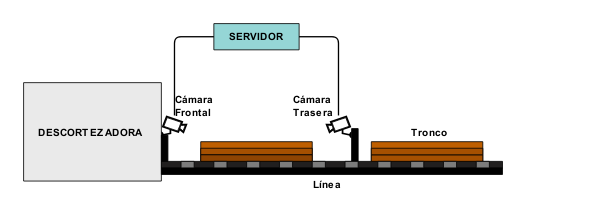

In [0]:
PIL.Image.open("schemeit-project.png")

Con un láser se detecta que viene un tronco por la línea, y cuando este pasa, se le toman 2 fotos, una de su cara frontal y otra de su cara trasera, en base a esto se puede estimar la cantidad de madera útil que se obtendrá del tronco luego de que este pase por los procesos de descortezado, cortado y pulido. Con estas imágenes en el servidor, además puede saberse cuántos troncos pasan por la máquina en un determinado periodo de tiempo, la calidad de estos troncos, y también el rendimiento de la máquina, en que momentos se detuvo la producción, e incluso con las fotos podría saberse la calidad de los troncos traídos por un determinado proveedor.

Actualmente el sistema de cámaras ya ha sido instalado, y cada vez que pasa un tronco se suben las imágenes de sus caras a un servidor.


##Problema de la solución actual:
Para poder conocer la cantidad de madera que puede extraerse de un determinado tronco, es necesario conocer el área de las caras de este a partir de las imágenes obtenidas por el sistema (Ver Figura 2).

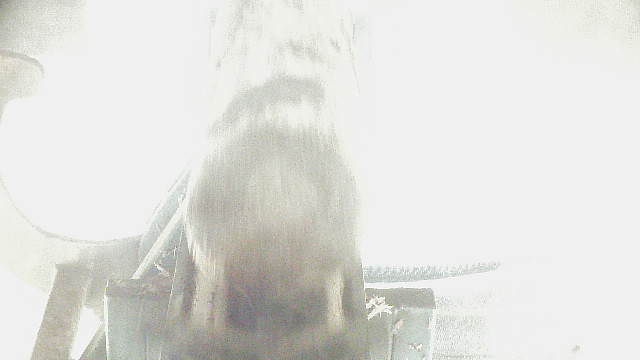

In [0]:
PIL.Image.open("1557156314_trunk1.jpg")

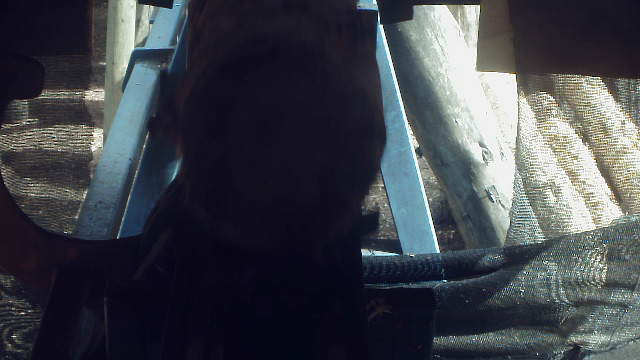

In [0]:
PIL.Image.open("1557159565_trunk1.jpg")

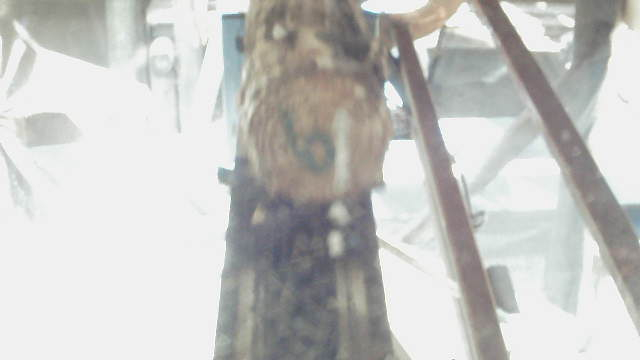

In [0]:
PIL.Image.open("1557170455_trunk2.jpg")

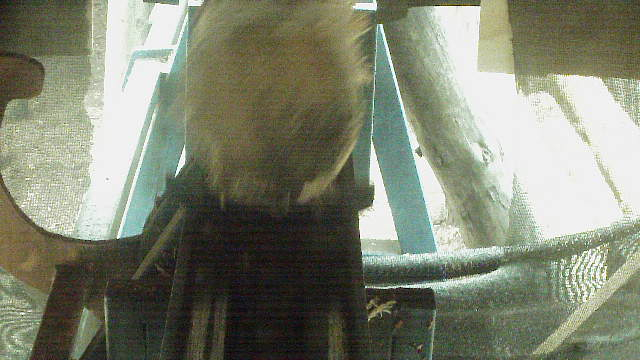

In [0]:
PIL.Image.open("1557178161_trunk1.jpg")

Al pensar en este problema, la segmentación de las caras de los troncos podría parecer una tarea fácil, pero al observar las imágenes, se puede ver que estas presentan varios problemas que dificultan bastante el uso de algoritmos de procesamiento de imágenes como lo son: 

1. **Iluminación:**  La iluminación varía mucho entre fotos, esto se debe a que el sistema recibe luz solar, la cual va variando durante el día, lo que hace que algunas fotos sean muy claras, y otras demasiado oscuras, también aparecen luces y sombras sobre algunas imágenes. 
2. **Movimiento**: Debido a que los troncos van pasando cuando se toman las fotos, algunas imágenes están movidas, en algunos casos es leve, y en otros bastante molesto, lo cual dificulta el obtener el contorno. 
3. **Diferencias entre troncos:** Cada tronco que pasa por la máquina es único, esto hace que algunos de ellos tengan diferentes tonalidades, formas, grietas, otros también están pintados con spray, y varios detalles que podrían confundir a los algoritmos de procesamiento de imágenes. 

Todas las razones antes mencionadas hacen que este sea un problema muy complejo de procesamiento de imágenes, y de acuerdo a la información entregada por la empresa, este se intentó resolver por 2 métodos, analizando los cambios de color entre pixeles y ajustando elipses, ambos métodos lograban el objetivo para algunas de las fotos, pero no entregaban resultados satisfactorios para todas ellas.

##Solución Propuesta:

A pesar de la gran variabilidad entre las imágenes, para una persona es posible realizar la segmentación luego de una inspección visual, y a pesar de haber partes del contorno que han desaparecido, sabiendo que los troncos tienen formas circulares, es posible estimar bastante bien la línea que seguirá el contorno. Con esto en cuenta, si un humano puede hacerlo, debería ser posible entrenar una máquina para esto.
Es por esto que se ha decidido optar por métodos de segmentación basados en “Deep Learning”. Estos métodos realizan un proceso llamado “Segmentación Semántica”, el cual consiste en clasificar cada pixel de una determinada imagen dentro de una clase. Para esto existen diversas arquitecturas de redes que se han ido desarrollando, las cuales tienen diferentes características. 
Para este problema se ha decidido utilizar la arquitectura U-Net (O. Ronneberger et al.,2015)1, la cual de acuerdo de los autores, permite realizar una buena segmentación con un dataset relativamente pequeño (utilizaron 30 imágenes en el paper), usando métodos de “Data Augmentation” que se describirán más adelante. 

##U-Net:

U-Net es una arquitectura de red que pertenece a un grupo conocido como las redes convolucionales-deconvolucionales, estas toman una determinada imagen, y a través de operaciones de convolución, ReLU y Pooling, obtienen las características de una imagen dada, y luego a través de la operación inversa (deconvoluciones, unpooling), logran reconstruir la imagen a partir de un vector reducido de características. En el caso de las redes que se utilizan para realizar segmentación semántica, en vez de reconstruir la imagen original, se reconstruye una versión segmentada de esta. Para ajustar los pesos de estas imágenes, es necesario realizar “Back Propagation” en base a una función de costo. Para esto, es necesario tener un dataset con imágenes segmentadas a mano, las cuales se van comparando con las segmentadas por la red para ajustar los pesos. Generalmente otras arquitecturas requieren “Datasets” de miles de imágenes segmentadas, pero para esta arquitectura, y de acuerdo a los autores, basta con tener algunas imágenes segmentadas (en el paper original utilizan solo 30), y tener buenos mecanismos de “Data Augmentation”
Para el caso específico de la red U-Net (Ver Figura 3), se tiene que además de utilizar la información de la capa anterior para realizar la reconstrucción de las imágenes, se utiliza información obtenida de antes de que se realizaran las convoluciones (flechas grises de la Figura 3), esto se debe a que cuando se realizan las convoluciones se pierden los bordes de las figuras a segmentar (esto por que la operación de convolución actúa como un filtro), por lo que al utilizar la información de antes de realizar las convoluciones para reconstruir nos asegura una segmentación más precisa, y una reconstrucción más nítida. 

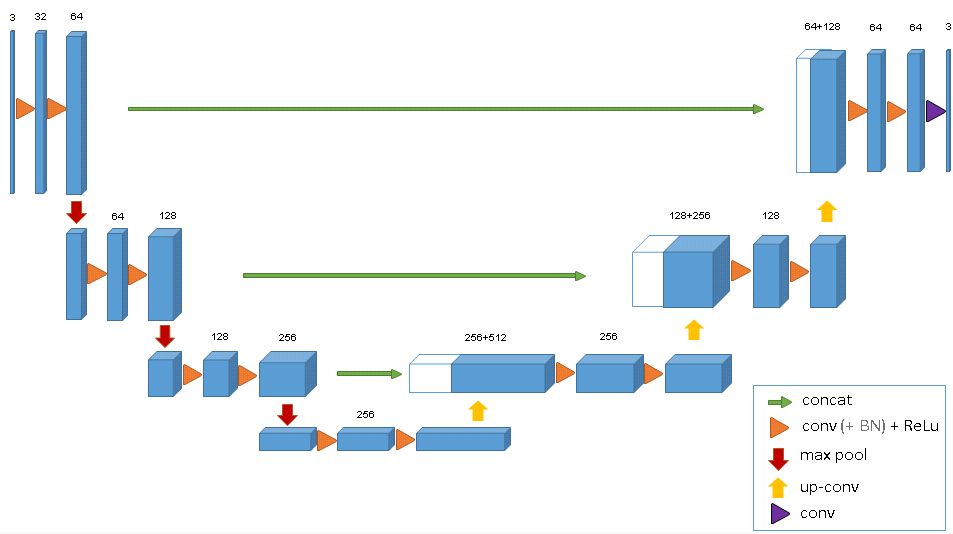

In [0]:
PIL.Image.open("Unet Arquitechture.png")

##Data:
El sistema mostrado en la Figura 1 ya se encuentra operativo, y es capaz de obtener imágenes de los troncos que van pasando por la línea, y enviarlas a un servidor, por lo que se cuenta con un Dataset de miles de imágenes, con diferentes tipos de troncos, luminosidad, y varios otros parámetros, además debido a que el sistema ya está en funcionamiento, se están obteniendo nuevas imágenes cada día, por lo que la obtención de las imágenes no representa un problema. Las características de las imágenes son: 
1. Dimensiones 		640 x 360
2. Formato		JPG
3. Tamaño		100 – 200 KB

##Segmentación de la Data:
Para poder utilizar la data disponible en entrenar la máquina, es necesario segmentar la data de manera manual, y obtener imágenes binarias, en que se tenga una clara separación entre el fondo y la cara del tronco 

# Implementación: 

In [0]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from google.colab import files

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  

Cargando los archivos de imagenes 

In [0]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Troncos.zip to Troncos.zip
User uploaded file "Troncos.zip" with length 101613701 bytes


Extraer los archivo de imagenes y mascaras de un archivo .**zip**, y almacenar los nombre de las imagenes

In [0]:
import zipfile


with zipfile.ZipFile('Troncos.zip', "r") as zip_ref:
 # unzipped_file = zip_ref.namelist()[0]
  zip_ref.extractall('Troncos')
  
zip_ref.close()

In [0]:
# Leer los nombre de los archivos
def read_frames_name(img_dir):
    
    # Get the file names list from provided directory
    file_list = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    
    # Separate frame and mask files lists, exclude unnecessary files
    frames_list = [file.replace(".jpg","") for file in file_list if ('_M' not in file) and ('zip' not in file)]

    return frames_list


In [0]:
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_mask.zip')
    


In [0]:
File_name = 'Troncos'
get_data(file_name)

In [0]:
img_dir = os.path.join(file_name, "train")
label_dir = os.path.join(file_name, "train_mask")
ids_train= read_frames_name(img_dir)

In [0]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_M.jpg".format(img_id)))

In [0]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.1, random_state=42)

In [0]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 657
Number of validation examples: 74


In [0]:
x_train_filenames[:10]

['Troncos/train/1557764784_trunk1.jpg',
 'Troncos/train/1557776680_trunk1.jpg',
 'Troncos/train/1557149989_trunk1.jpg',
 'Troncos/train/1557159565_trunk1.jpg',
 'Troncos/train/1557158932_trunk2.jpg',
 'Troncos/train/1557775422_trunk1.jpg',
 'Troncos/train/1557159259_trunk2.jpg',
 'Troncos/train/1557148884_trunk1.jpg',
 'Troncos/train/1557159124_trunk1.jpg',
 'Troncos/train/1557144824_trunk1.jpg']

In [0]:
y_train_filenames[:10]

['Troncos/train_mask/1557764784_trunk1_M.jpg',
 'Troncos/train_mask/1557776680_trunk1_M.jpg',
 'Troncos/train_mask/1557149989_trunk1_M.jpg',
 'Troncos/train_mask/1557159565_trunk1_M.jpg',
 'Troncos/train_mask/1557158932_trunk2_M.jpg',
 'Troncos/train_mask/1557775422_trunk1_M.jpg',
 'Troncos/train_mask/1557159259_trunk2_M.jpg',
 'Troncos/train_mask/1557148884_trunk1_M.jpg',
 'Troncos/train_mask/1557159124_trunk1_M.jpg',
 'Troncos/train_mask/1557144824_trunk1_M.jpg']

# Visualizando el data set


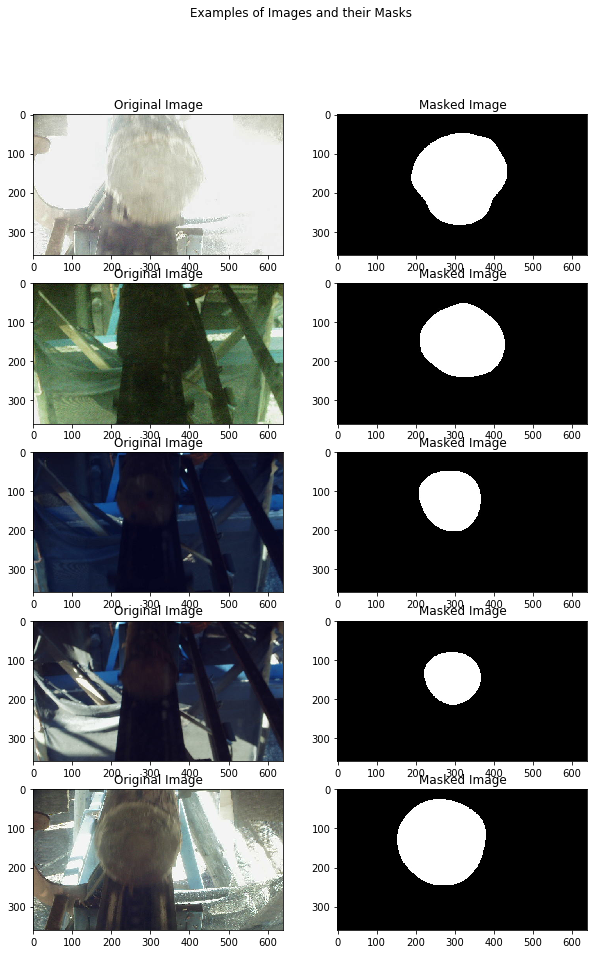

In [0]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  #example_labels = Image.open(y_pathname)
  #label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i + 2)
  #plt.imshow(example_labels)
  plt.imshow(mpimg.imread(y_pathname))
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

# Incialización

In [0]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 50

Es importante destacar que para el uso de la arquitectura de la red UNET utilizada es necesario que el tamaño  debe ser divisible en un tamaño de 32, para mantener la simetria y realizar la reduccion entre dos en cada `MaxPooling2Dlayer`.


# Lectura y pre-procesamiento de las imagenes 

Lectura de las imagenes original y su mascara con la segmentación, de acerdo al formato 

### Aplicar transformación de imagenes:
1. Modificar el tamaño de imagen
2. Ajustar el HUE (aparencia de color) de una imagen RGB a un factor aleatorio entre 
  [0, 0.5]
3. Desplazamiento horizontal, vertical y reescalando la imagen en un factor de 1/255
4. Mezcla de Data
 
### Importancia de la trnasformacion de imagenes 

Es de gran importancia la transformacion de imagenes para obtener un aumento en el set de data de entrada y de esta manera asegurar que la red no vea simpre la misma imagen dos veces durante el entrenamiento. y de esta forma evitar el "overfitting"


## Lectura de la imagen y de la mascara

In [0]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.read_file(fname)
  img = tf.image.decode_jpeg(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_jpeg(label_img_str, channels=1)
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

## Desplazamiento de la imagen

In [0]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """This fn will perform the horizontal or vertical shift"""
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
      # Translate both 
      output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
      label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
  return output_img, label_img

##Espejo horizontal

In [0]:
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

## Aumentando el data set usando las transformaciones de imagenes 

In [0]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)
  
  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)
  
  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  label_img = tf.to_float(label_img) * scale
  img = tf.to_float(img) * scale 
  return img, label_img

In [0]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

##Configuración del conjuntos de datos de entrenamiento y validación.

Es importante resaltar que las transformaciones solo fueron aplicadas al set de entrenamiento, y no al de validación.


In [0]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [0]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [0]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

## Observando los resultados de la transformaciones de imagenes para el incremento del data set 

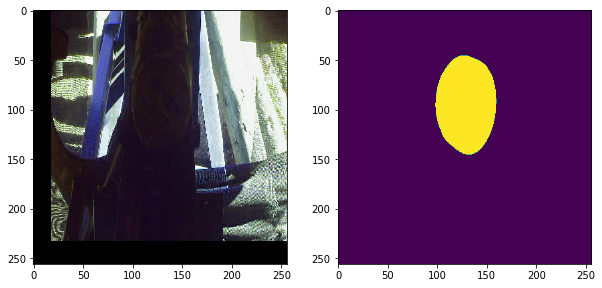

In [0]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=10,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0])
  plt.show()

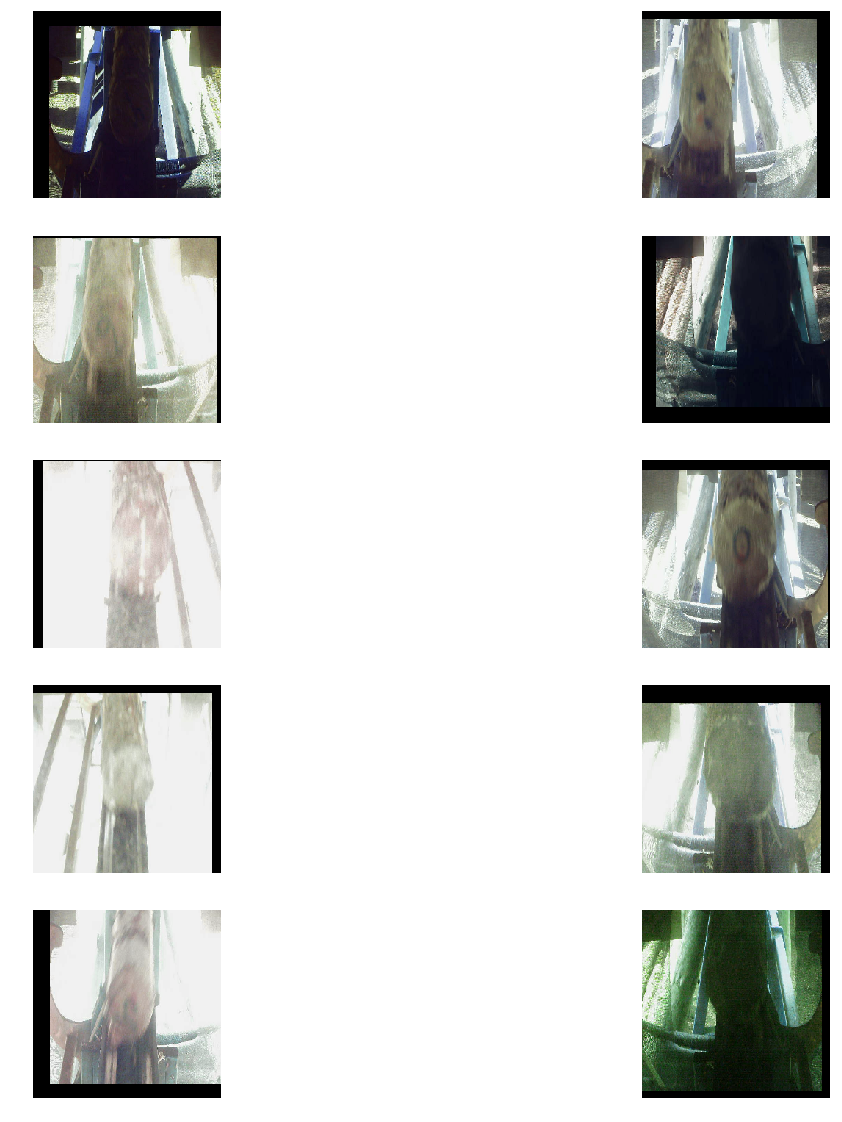

In [0]:
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(20, 20))
  for i in range(10):
    img = batch_of_imgs[i]
  
    plt.subplot(5, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
    
    

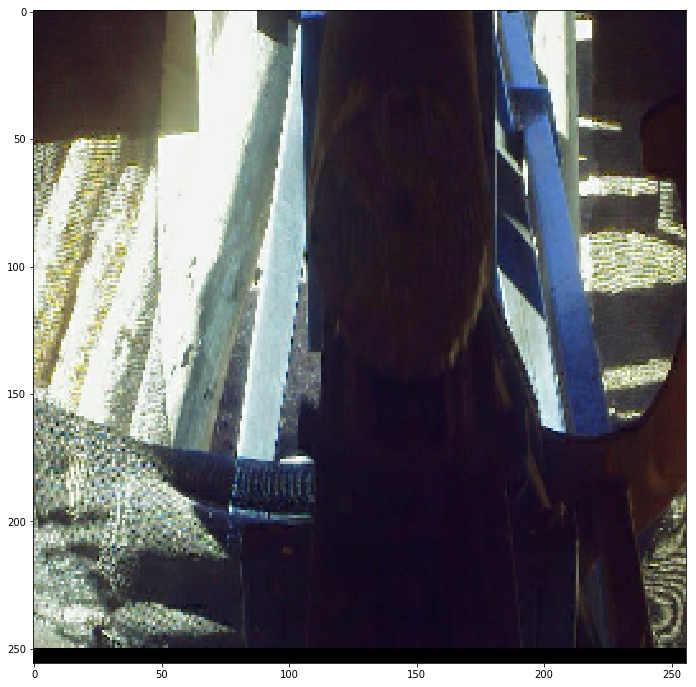

In [0]:
plt.imshow(batch_of_imgs[1])

# Construcción del modelo
La red red U-Net es epecialmente buena para segemnetar imagenes ya que puede localizar de forma apropiada y generar la segementacion con alta resolucion. Ademas trabaja muy bien con pequeños data set y es relativamente robusto contra overfitting.

In [0]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [0]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [0]:
model = models.Model(inputs=[inputs], outputs=[outputs])

# Definicion de las metricas y la funcion de costo

Dice coefficient: 2 ∗ (Seg_Real ∩ Seg_Estimada)/(Seg_Real + Seg_Estimada),
aciertos contra el total.

Ademas se utilizó cross entropy ya es mas facil maximizar la funcion objetivo.

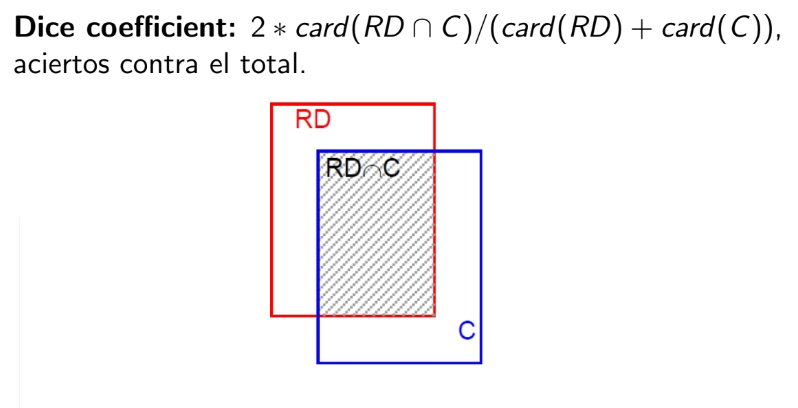

In [0]:
import PIL
PIL.Image.open("Dice.png")


In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [0]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## Compilando el modelo
Se usa la función de pérdida para minimizar. Además, se especifica las métricas para hacer un seguimiento mientras se entrena. Las métricas no se utilizan realmente durante el proceso de capacitación para ajustar los parámetros, sino que se usan para medir el rendimiento del proceso de capacitación.

In [0]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

W0619 18:53:45.216522 139820573333376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 256, 256, 32) 128         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 256, 256, 32) 0           batch_normalization_27[0][0]     
______________________________________________________________________________________________

## Entrenar el modelo



In [0]:
save_model_path = 'weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [0]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Epoch 1/50
218/219 [============================>.] - ETA: 0s - loss: 0.6227 - dice_loss: 0.4011
Epoch 00001: val_dice_loss improved from inf to 0.76344, saving model to weights.hdf5
219/219 [==============================] - 58s 263ms/step - loss: 0.6246 - dice_loss: 0.4019 - val_loss: 13.4386 - val_dice_loss: 0.7634
Epoch 2/50
218/219 [============================>.] - ETA: 0s - loss: 0.3913 - dice_loss: 0.2500
Epoch 00002: val_dice_loss improved from 0.76344 to 0.46905, saving model to weights.hdf5
219/219 [==============================] - 35s 161ms/step - loss: 0.3911 - dice_loss: 0.2499 - val_loss: 1.9663 - val_dice_loss: 0.4690
Epoch 3/50
218/219 [============================>.] - ETA: 0s - loss: 0.3214 - dice_loss: 0.2059
Epoch 00003: val_dice_loss improved from 0.46905 to 0.18099, saving model to weights.hdf5
219/219 [==============================] - 34s 157ms/step - loss: 0.3219 - dice_loss: 0.2062 - val_loss: 0.3912 - val_dice_loss: 0.1810
Epoch 4/50
218/219 [==============

In [0]:
#from google.colab import files
files.download(save_model_path)

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 34134, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

# Visualize training process

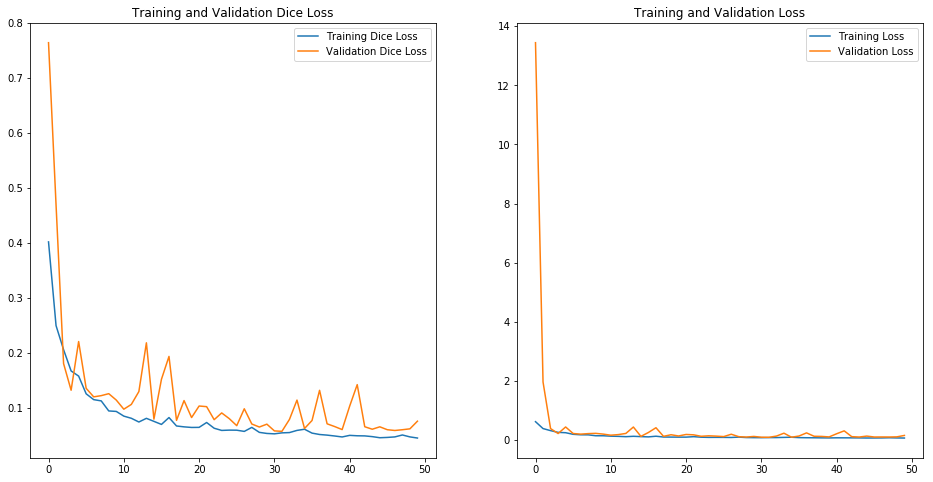

In [0]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Visualizando el resultado

In [0]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

W0619 19:39:33.380252 139820573333376 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0619 19:39:33.383045 139820573333376 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0619 19:39:33.389445 139820573333376 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

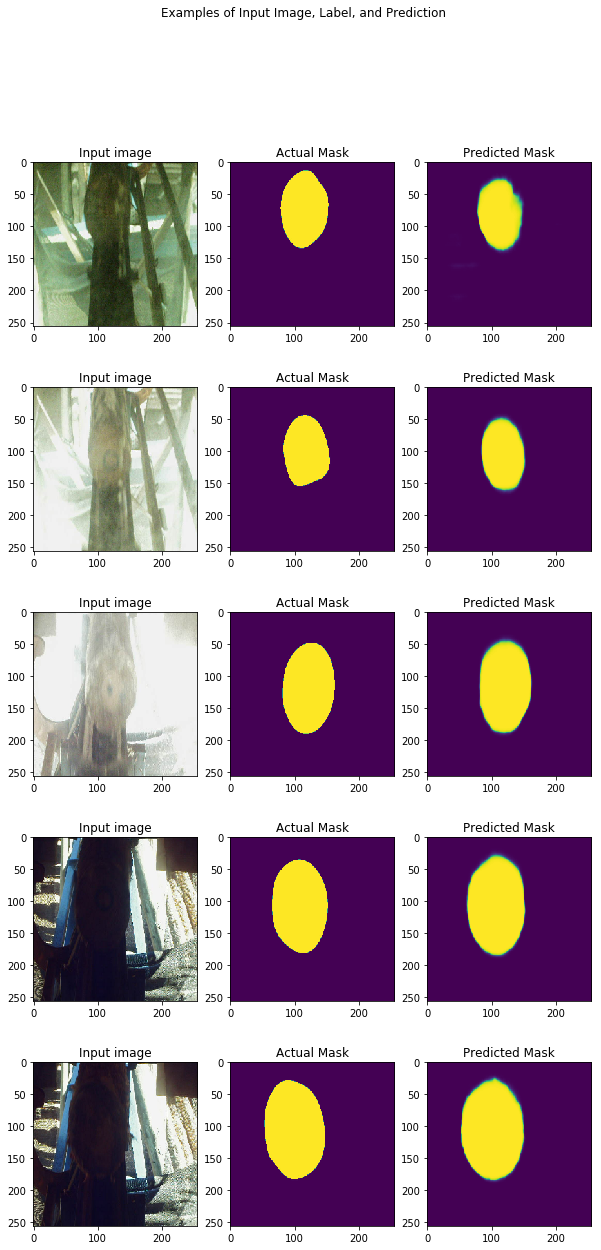

In [0]:
# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, 0])
  plt.title("Actual Mask")
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, 0])
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

# Referencias:

MarkDaoust, raymond-yuan, "Image Segmentation with tf.keras", disponible en: https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb

Olaf Ronneberger, Philipp Fischer, Thomas Brox "U-Net: Convolutional Networks for Biomedical Image Segmentation" Medical Image Computing and Computer-Assisted Intervention (MICCAI), Springer, LNCS, Vol.9351: 234--241, 2015

[Video presentación](https://www.youtube.com/watch?v=A3PmfpJmcNA)
